# 2 Class model CV score & Training Analysis

In [37]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from glob import glob
import os

In [38]:
def load_history(folder):
    history = []
    for dirname, _, filename in os.walk(folder):
        for file in filename:
            if file.split('.')[-1] == 'csv':
                history.append(os.path.join(dirname, file))
    model = folder.strip('./')
    return sorted(history), model

def draw_history(history, model):
    rows = 3
    cols = 2
    fig, axes = plt.subplots(rows, cols, figsize=(16,16))

    for i in range(6):                  # columns
        for j in range(5):              # kfold
            tmp = pd.read_csv(history[j]).iloc[:,i]
            length = tmp.shape[0]
            axes[i//cols][i%cols].plot(tmp, label=f"Fold {j}", 
                                       alpha=0.4, marker='o',
                                       linewidth=0.8, markersize=4)
        axes[i//cols][i%cols].set_xticks(np.arange(length))
        axes[i//cols][i%cols].set_xticklabels(np.arange(length))
        axes[i//cols][i%cols].grid()
        axes[i//cols][i%cols].set_title(f"{tmp.name}", weight='bold', loc='left', size=14)
        axes[i//cols][i%cols].legend(loc='best')
        
    plt.suptitle(f" Model history", weight='bold', size = 20)
    plt.show();

def check_val_loss_lr(history):    
    rows = 3
    cols = 2
    fig, axes = plt.subplots(rows, cols, figsize=(12,12))

    for i in range(5):
        tmp = pd.read_csv(history[i]).iloc[:,[0,3,5]]
        length = tmp.shape[0]
        axes[i//cols][i%cols].plot(tmp.iloc[:,1], 
                                   label=f"{tmp.columns[1]}", 
                                   alpha=0.6, marker='o',
                                   linewidth=0.8, markersize=4)
        
        axes[i//cols][i%cols].plot(tmp.iloc[:,2]*1000, 
                                   label=f"{tmp.columns[2]} * 1000", 
                                   alpha=0.6, marker='^',
                                   linewidth=0.8, markersize=4)
        
        tmp = tmp[tmp['val_loss']==tmp.iloc[:,1].min()]
        
        axes[i//cols][i%cols].axvline(x = tmp.iloc[0,0], linestyle='--', color='red', alpha= 0.5)
        axes[i//cols][i%cols].set_title(f"Fold {i}", weight='bold', loc='left', size=14)
        axes[i//cols][i%cols].legend(loc='best')
        axes[i//cols][i%cols].set_xticks(np.arange(length))
        axes[i//cols][i%cols].set_xticklabels(np.arange(length))
        axes[i//cols][i%cols].grid(linewidth=0.5)
    
    plt.suptitle(f"check val_loss & lr by Fold", weight='bold', size=20)
    plt.tight_layout()
    plt.show();    
    
def draw_plot(folder):
    history, model = load_history(folder)
    
    val_losses = []
    val_auces = []
    epochs = []

    for path in history:
        temp = pd.read_csv(path)
        temp = temp[temp['val_loss']==temp['val_loss'].min()]
        
        val_losses.append(temp.iloc[0,3])
        val_auces.append(temp.iloc[0,4])
        epochs.append(temp.iloc[0,0])
    
    plt.figure(figsize=(8,5))
    
    plt.bar(np.arange(0,5),val_auces, color='dodgerblue', edgecolor='black', 
            linewidth=0.4, width=0.6, alpha = 0.6)
    plt.bar(np.arange(0,5),val_losses, color='springgreen', edgecolor='black', 
            linewidth=0.4, width=0.6, alpha = 0.8)
    
    plt.xticks(np.arange(0,5), epochs)
    plt.xlabel('epochs at best')
    
    for i in range(0,5):
        plt.text(x = i-0.1, y = val_auces[i]+0.01, s = f"{val_auces[i]:.3f}")
        plt.text(x = i-0.1, y = val_losses[i]+0.01, s = f"{val_losses[i]:.3f}")
        
    plt.axhline(y=np.mean(val_auces),color='r', linestyle='--')
    plt.text(x = 0, y = np.mean(val_auces)-0.05, s = f"mean val_auc : {np.mean(val_auces):.3f}",
             weight='bold', size=12)
    
    plt.axhline(y=np.mean(val_losses),color='r', linestyle='--')
    plt.text(x = 0, y = np.mean(val_losses)-0.05, s = f"mean val_loss : {np.mean(val_losses):.3f}",
             weight='bold', size=12)

    plt.title(f"{model} Kfold (validation)", weight='bold', size=16, loc='left')
    plt.show();

    # draw training history
    draw_history(history, model)
    # check validation loss & learning rate at best epoch
    check_val_loss_lr(history)  

## 1. effnb7 Kfold

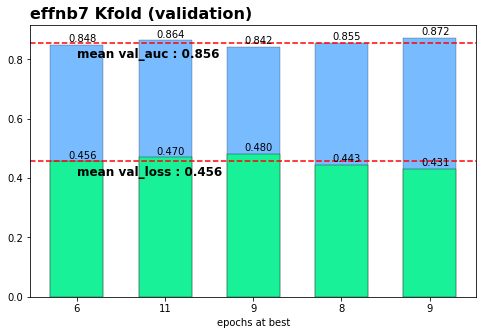

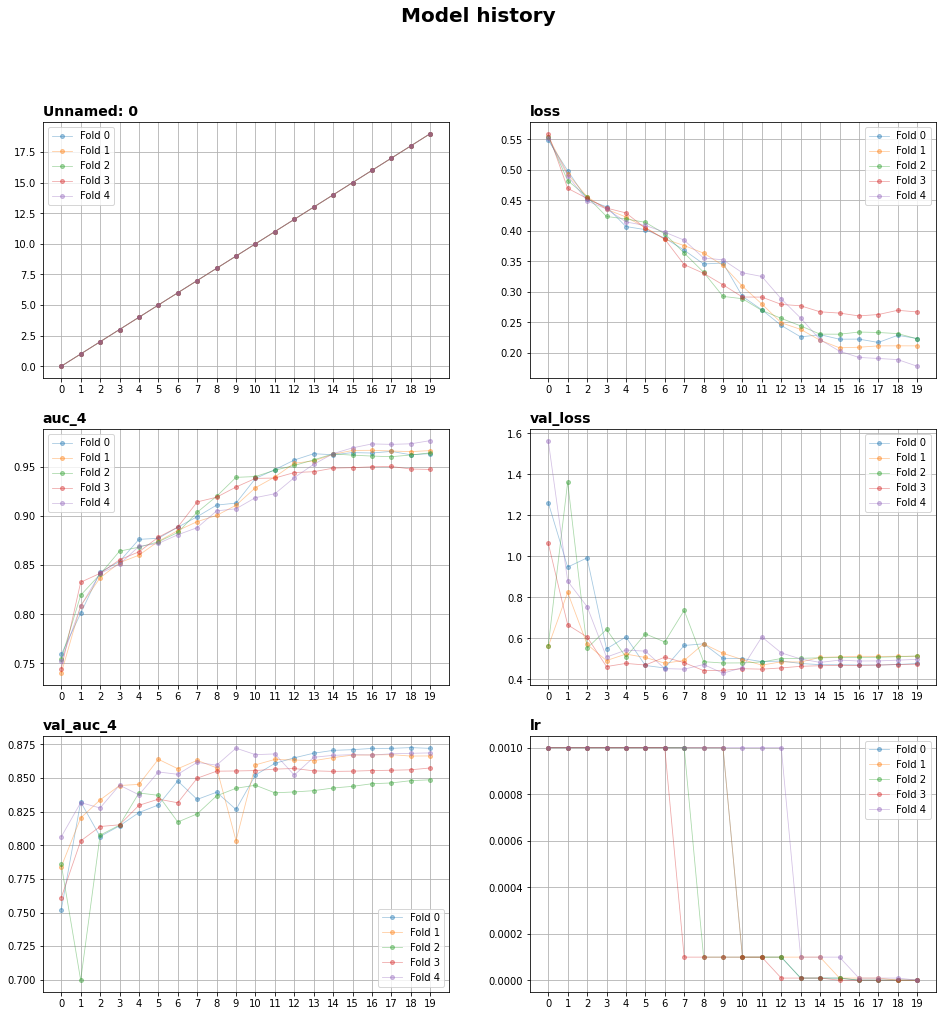

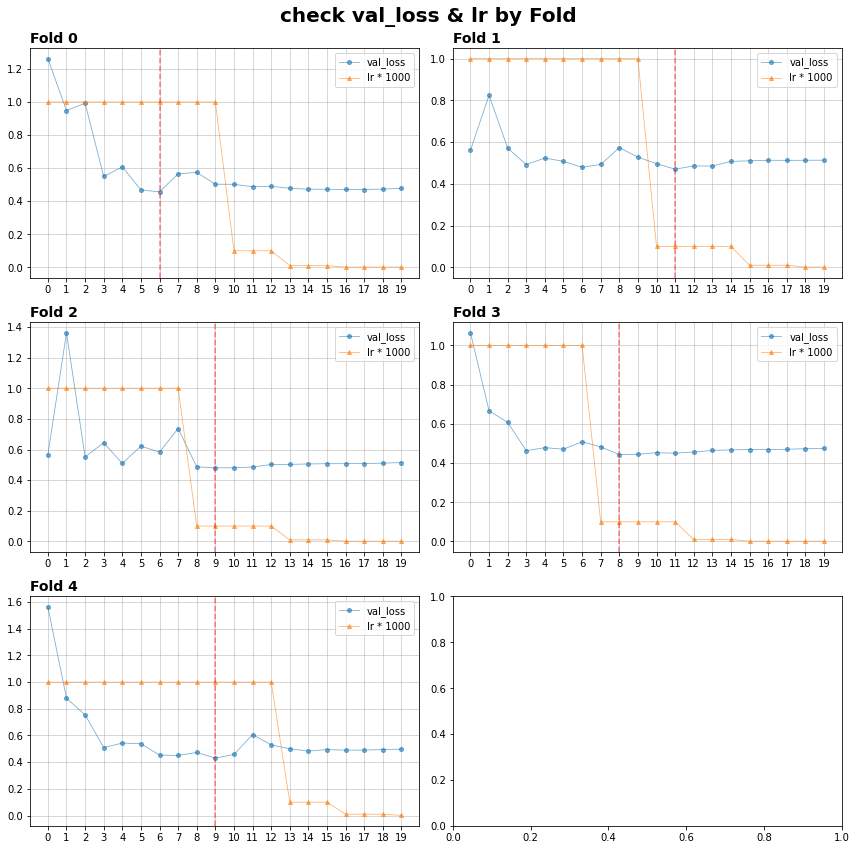

In [39]:
draw_plot(folder='./effnb7/')

### EfficientNetB7 kfold - default
* global average pooling
* augmentation : flip left right, flip up down

## 2. effnV2 Kfold

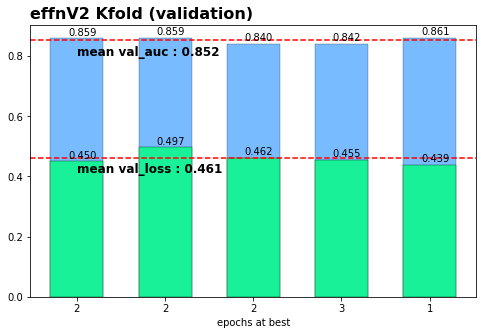

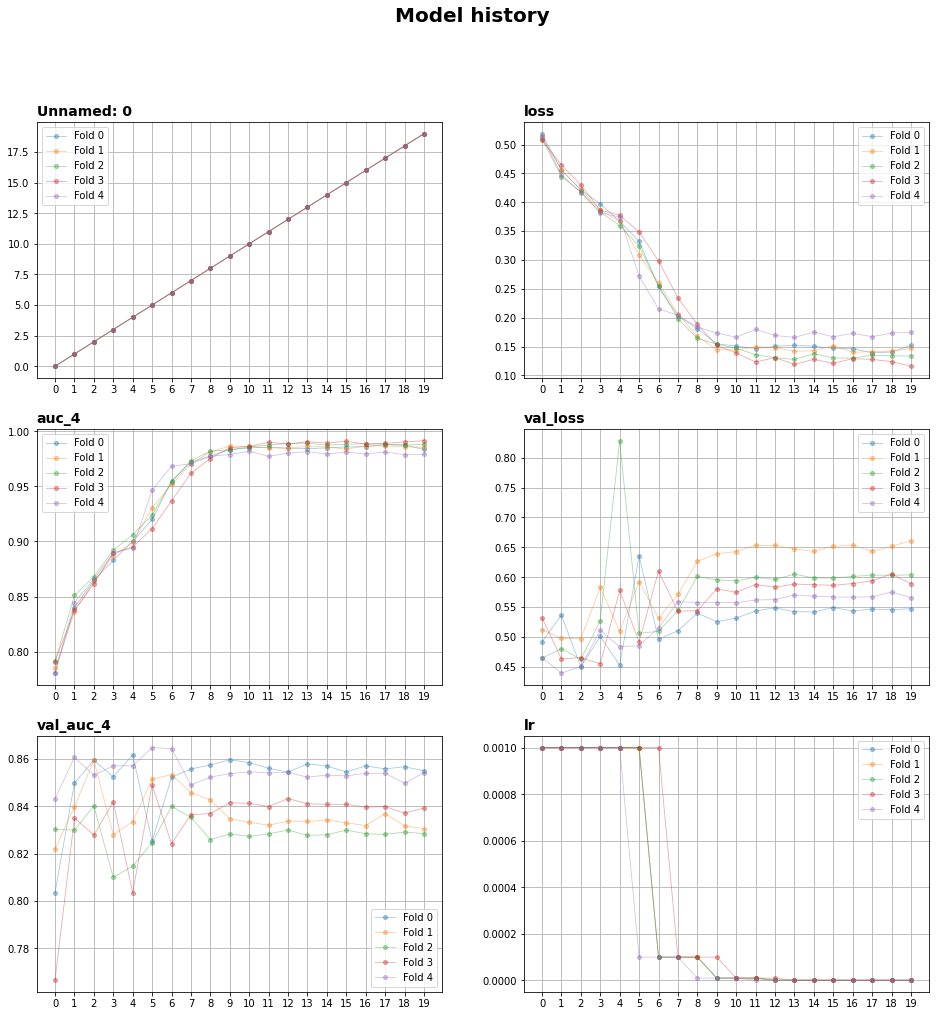

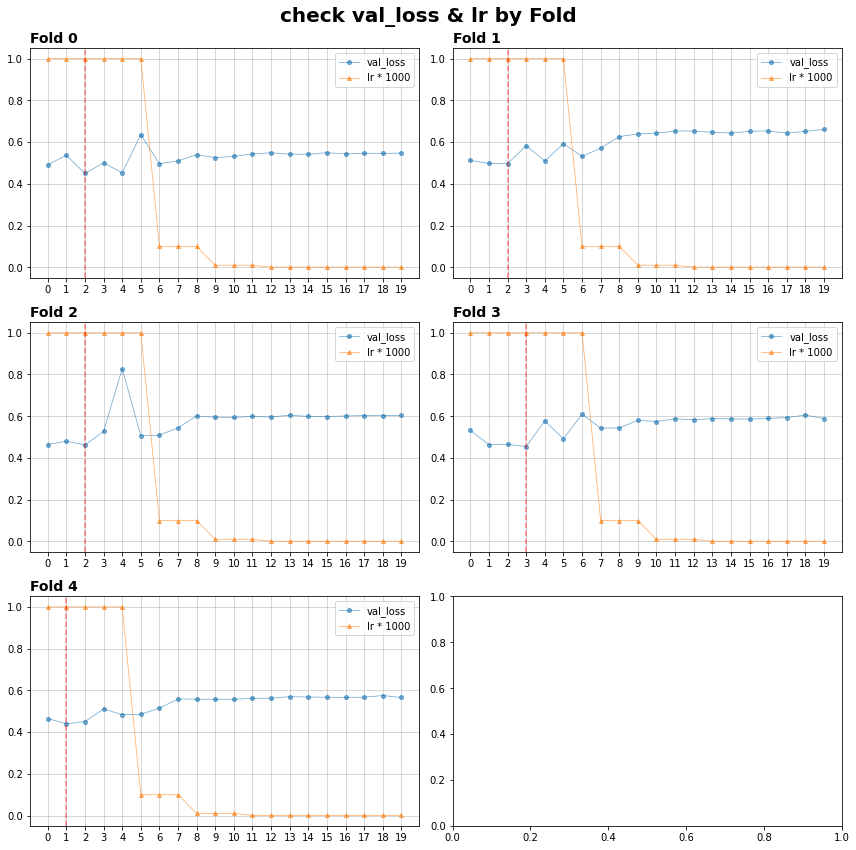

In [40]:
draw_plot(folder='./effnV2/')

### EfficientNetV2_large
* dropout 0.1 without global average pooling
* augmentation : flip left, right, saturation, contrast, brightness  

왜 성능이 더 떨어질까?  
그리고 아까는 분명 더 좋았는데, 어디서 실험 seed 고정 차이가 나는걸까?  
데이터 셋 문제라면 groupkfold 의 sampling 차이인가?

* **두 모델 비교**  
지금 보면 V2 와 B7 이 best epochs 에 도달하는 시점이 매우 차이난다.  
V2 : 2,2,2,3,1  
B7 : 6,11,9,8,9   
왜 차이가 많이 나는걸까?  
일단, 모델이 거대해서 더 빨리 minima 에 빠질 수는 있겠지만, local minima 에 빠져버린 것은 아닐까?  
제대로 학습하려면 learning rate 및 scheduler 를 좀 더 조정할 필요가 있지 않을까?  
augmentation 을 변경하여 학습시킨 모델과도 비교해보자.

* **training - learning rate scheduler & optimization**  
현재 학습되는 것을 보면, epochs 를 더 오래 두면 뭔가 더 좋아질 것 같다는 생각도 든다.    
learning_rate best epochs 에서 바로 조정해주면 좋을 것 같은데.  
callbacks 의 plateau 나 lr scheduler 를 활용하면 좋은데, 그 많은 변수를 어떻게 해야 하나?   
아. 기본적으로 지금은 lr 이 plateau 기반 변화이므로, 계속 변하지 않고 학습된다.  
plateau 걸리면 그때 줄이는데, 이미 늦을지도.  
그래서 scheduler 사용해봐야겠다.  
어떻게 제대로 사용하는지는 모르지만, 학습그래프를 그려보고 그것을 바탕으로 분석하여 스케쥴러를 짜보자.  
& 스케쥴러 관련 자료가 있는지 찾아보자.  

[TF callbacks](https://www.tensorflow.org/api_docs/python/tf/keras/callbacks/ReduceLROnPlateau)

## 3. effnV2_version2 Kfold

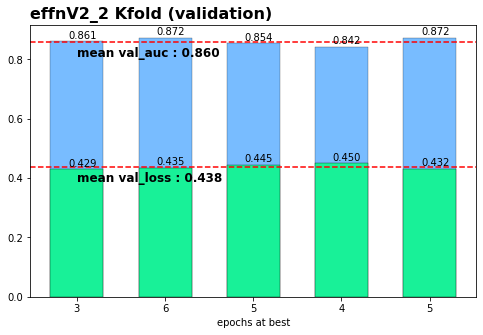

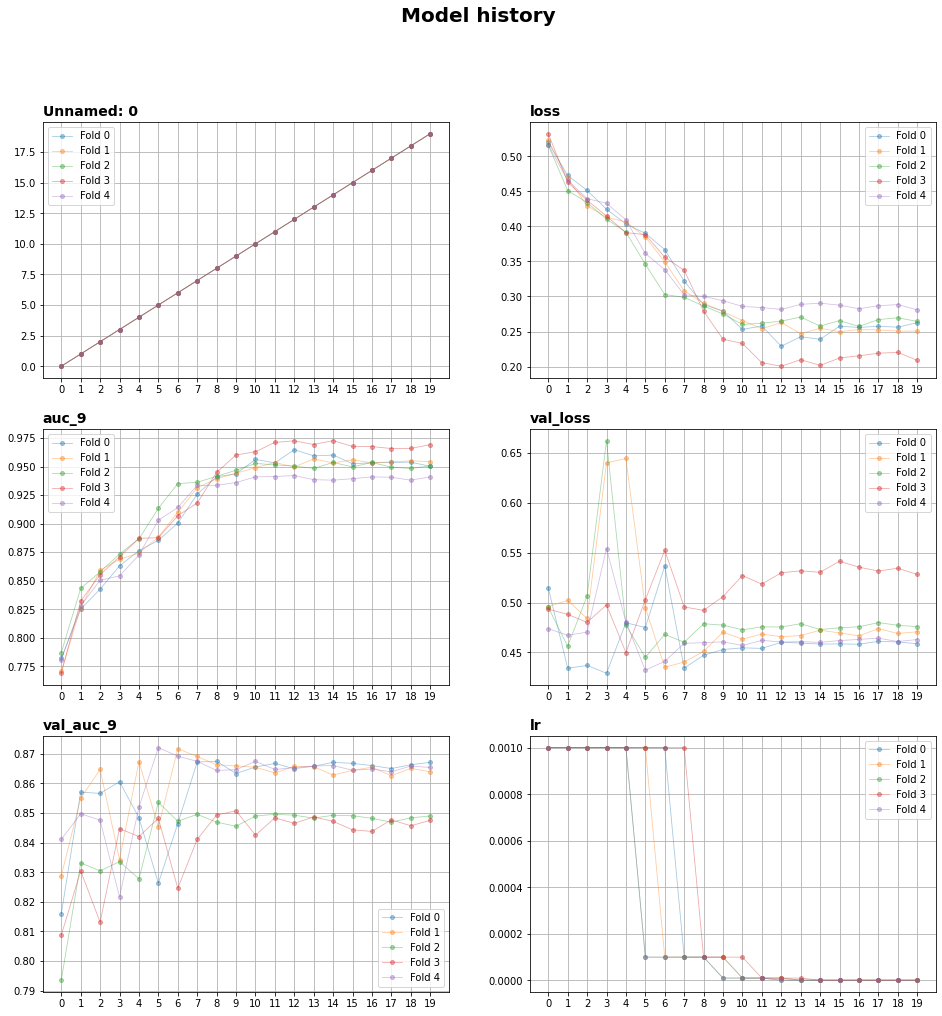

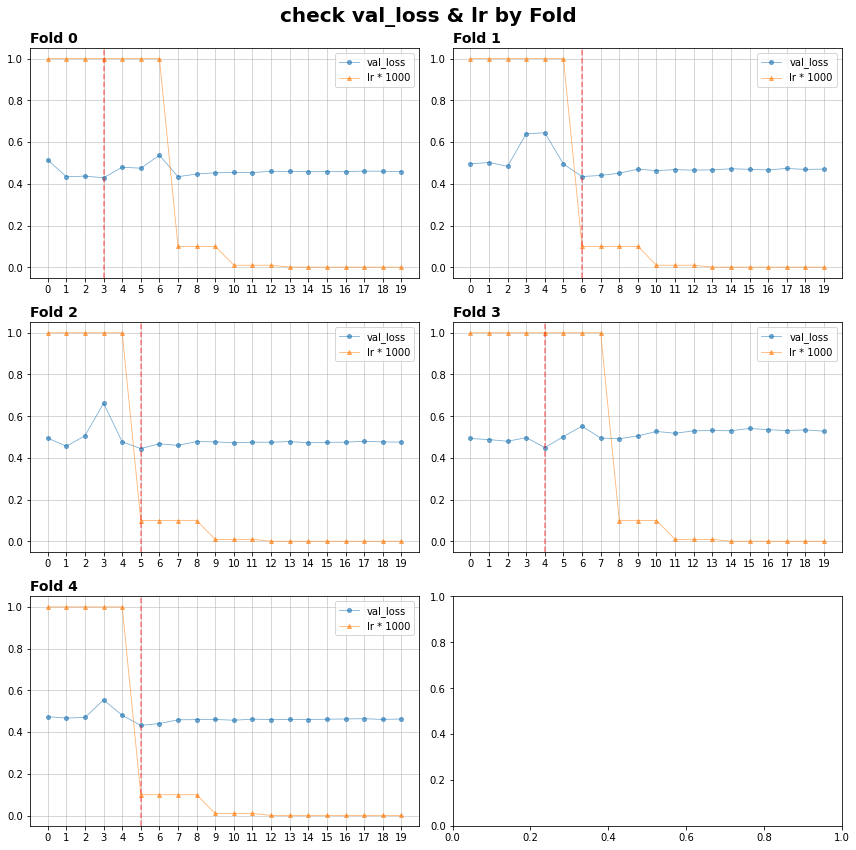

In [41]:
draw_plot(folder='./effnV2_2/')

## 4. effnb7 Kfold : New Data 로 학습한 모델

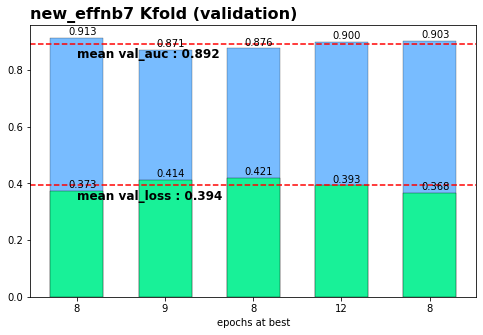

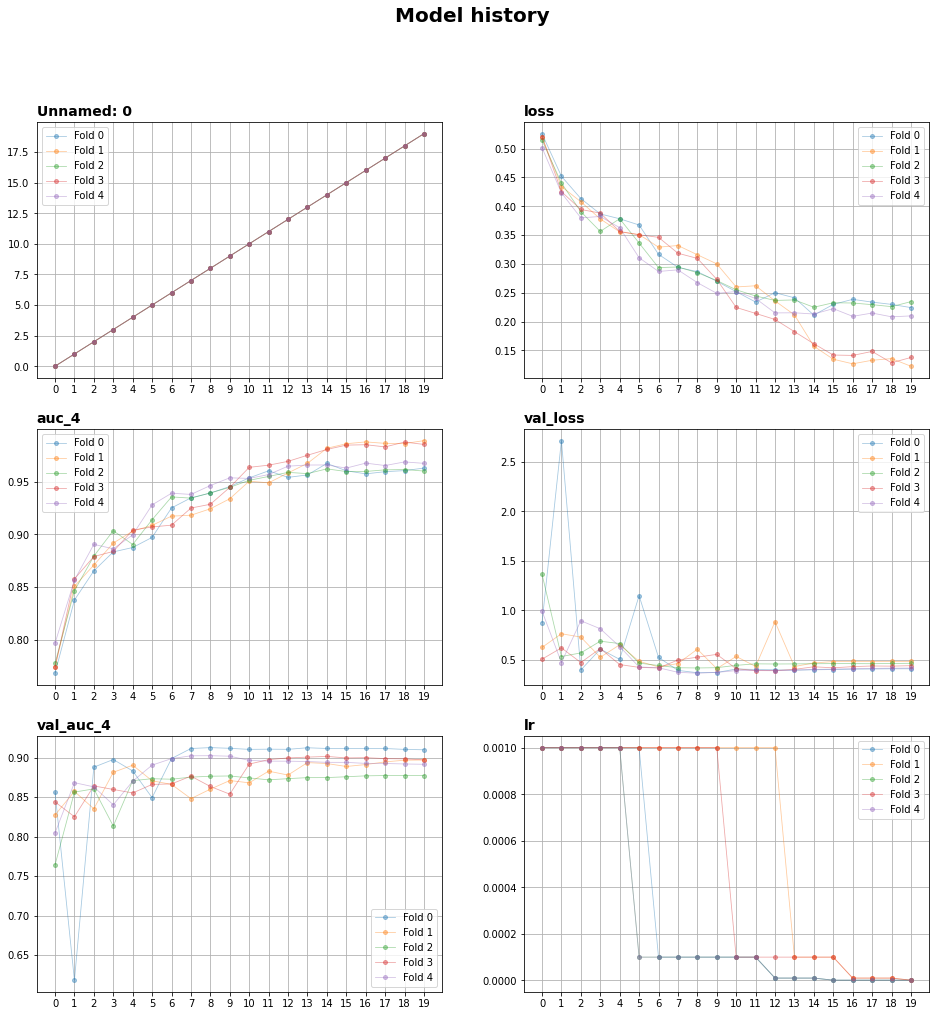

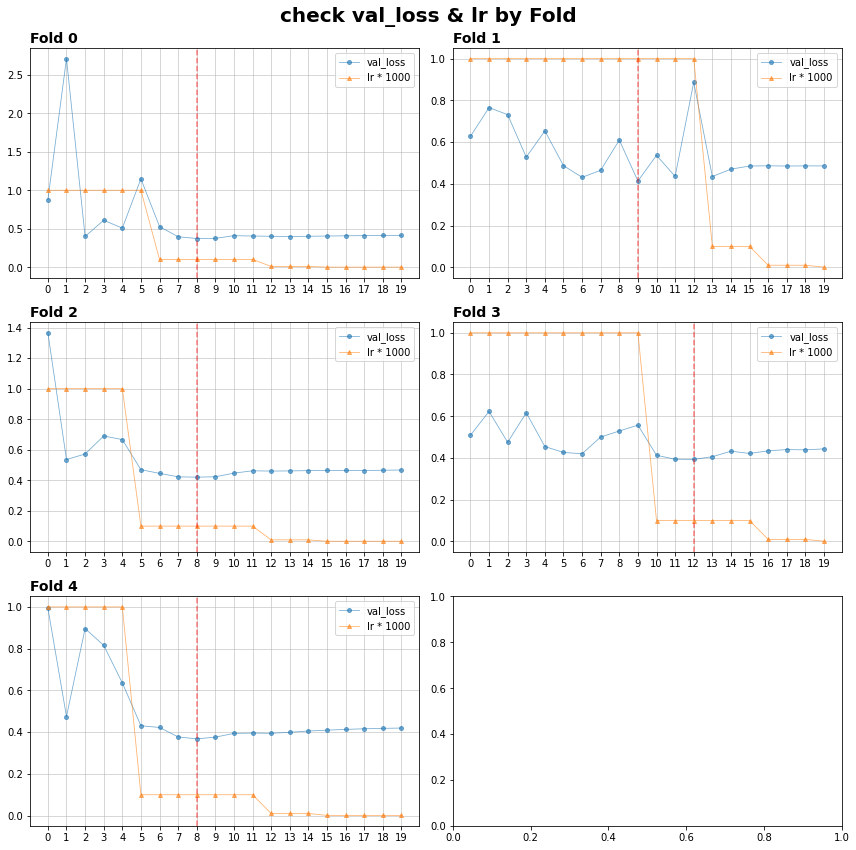

In [42]:
draw_plot(folder='./new_effnb7/')

## 5. effnV2_XL Kfold : New data 로 학습한 모델

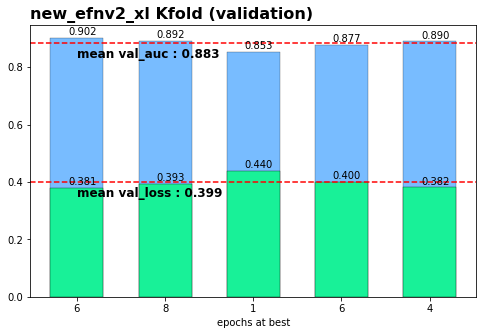

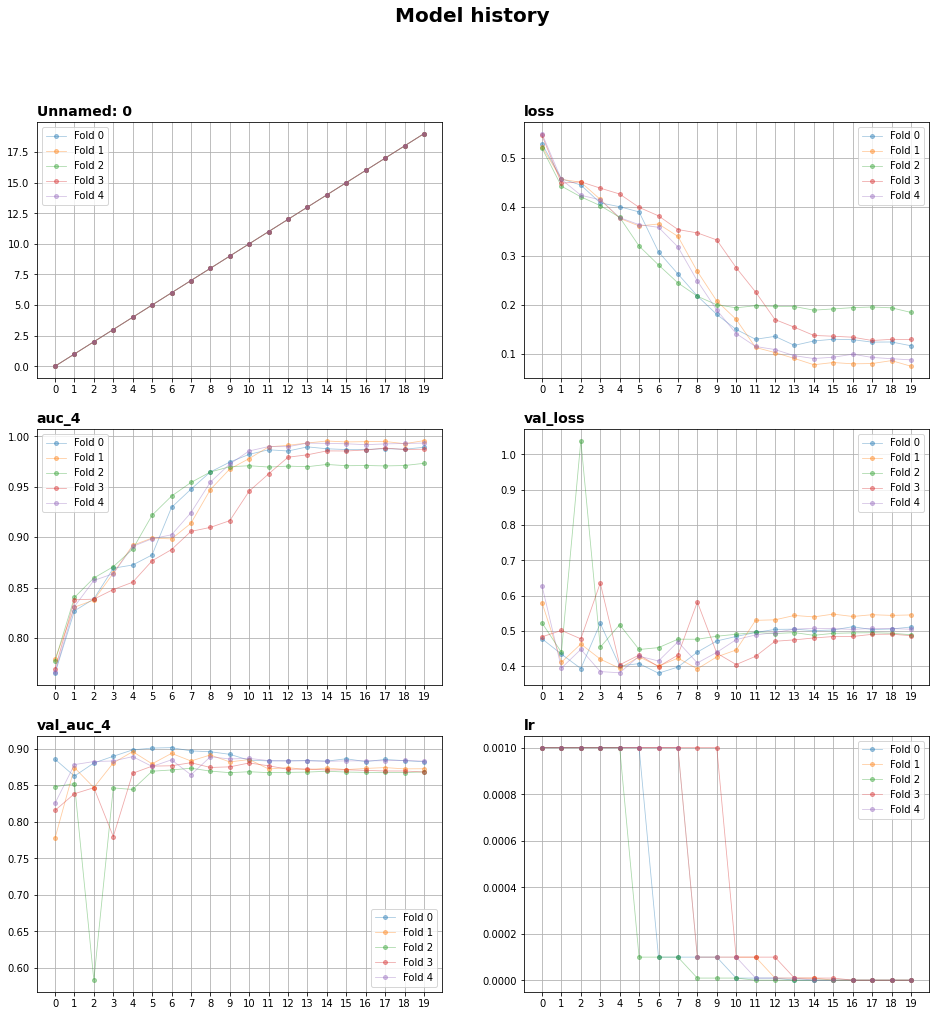

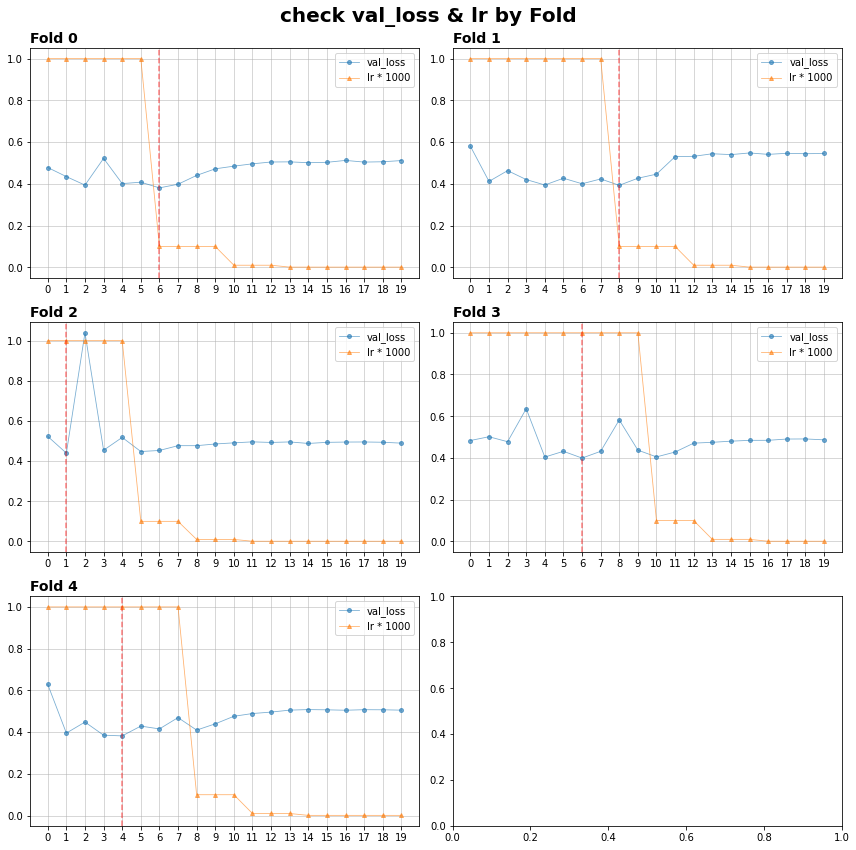

In [43]:
draw_plot(folder='./new_efnv2_xl/')

## 6. effnb7 Kfold with cutmix : New data

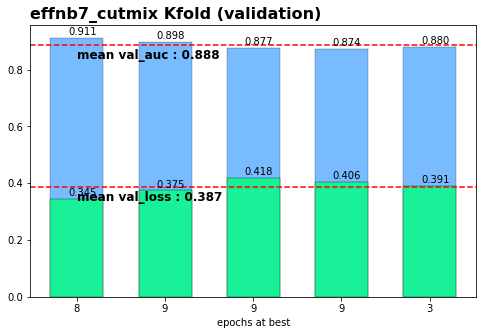

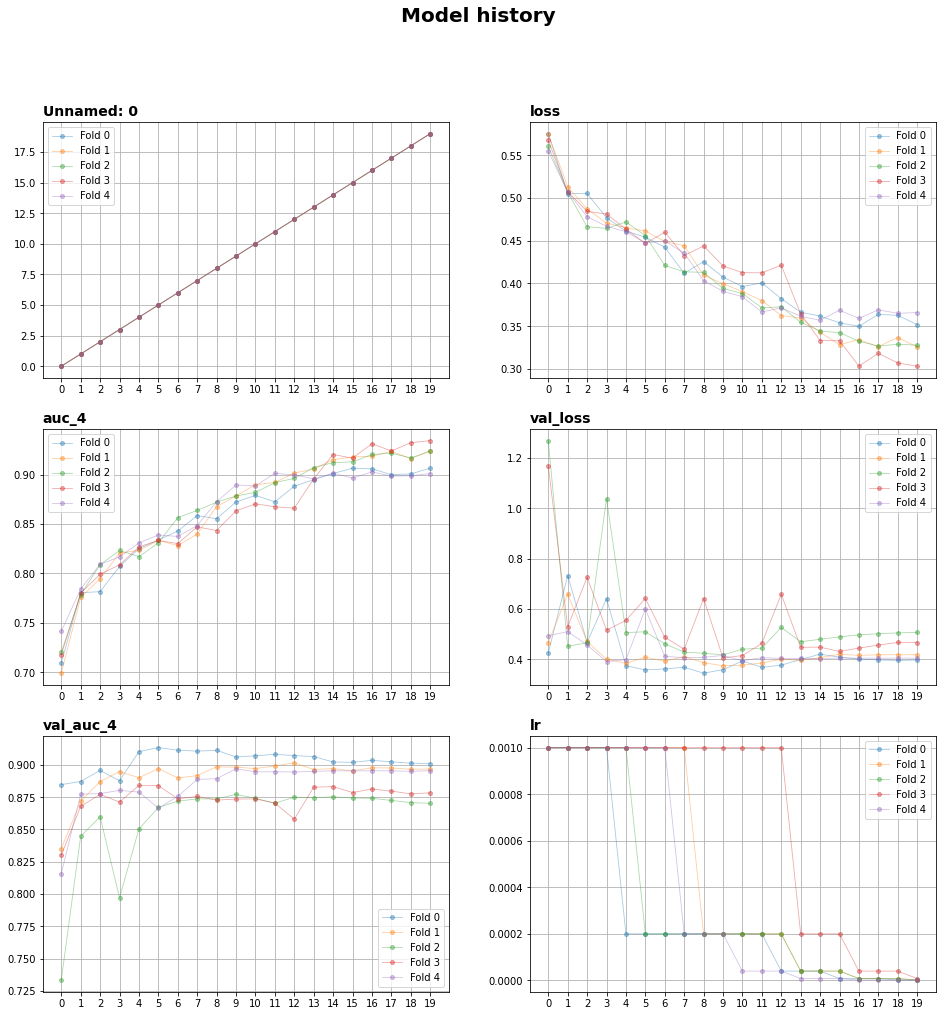

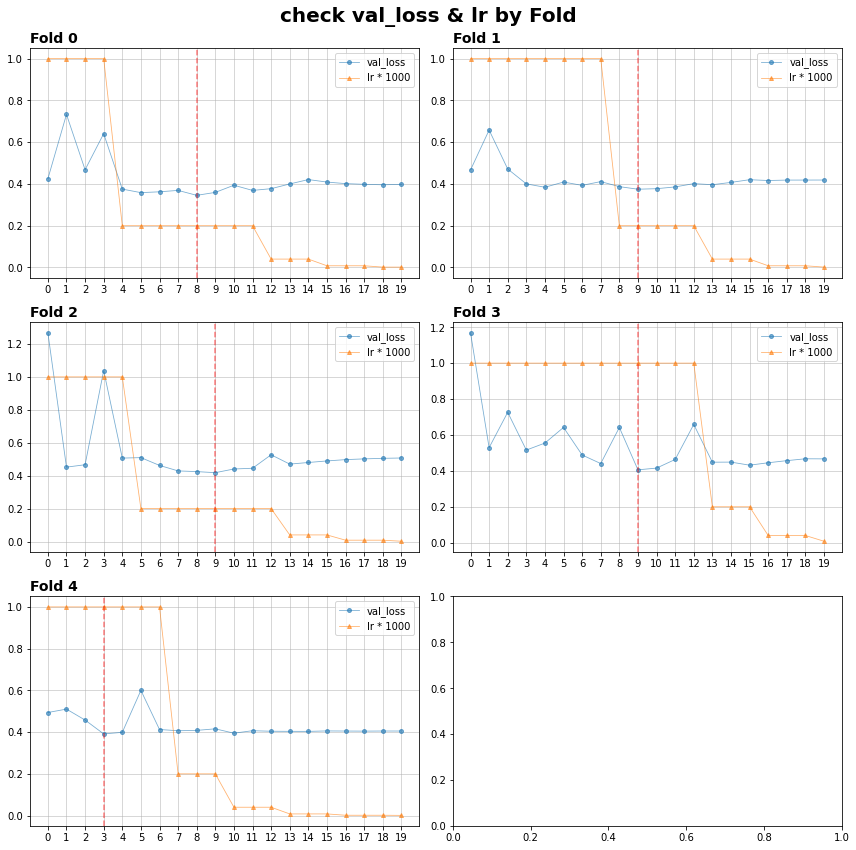

In [44]:
draw_plot(folder='./effnb7_cutmix/')

## 7. effnV2_XL Kfold with cutmix : New data

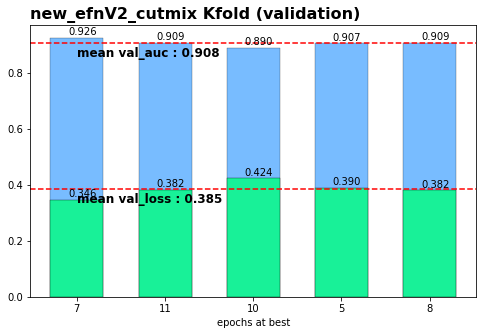

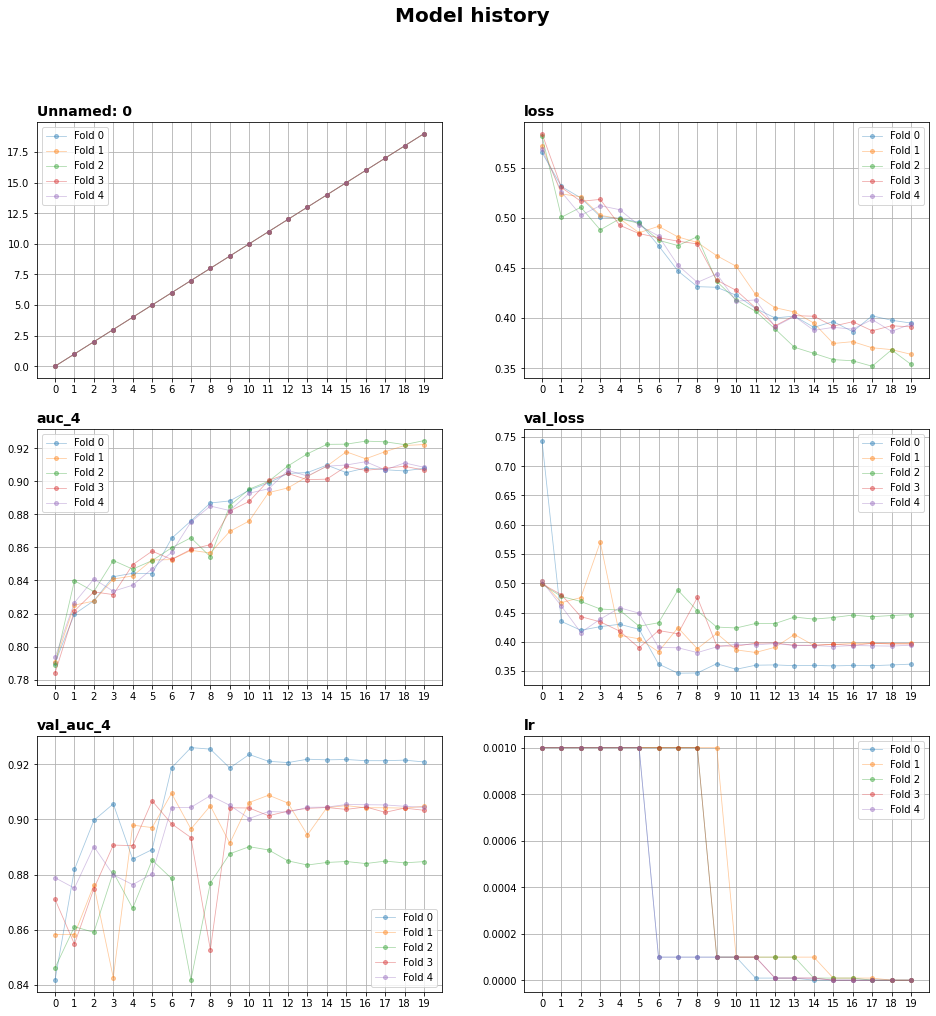

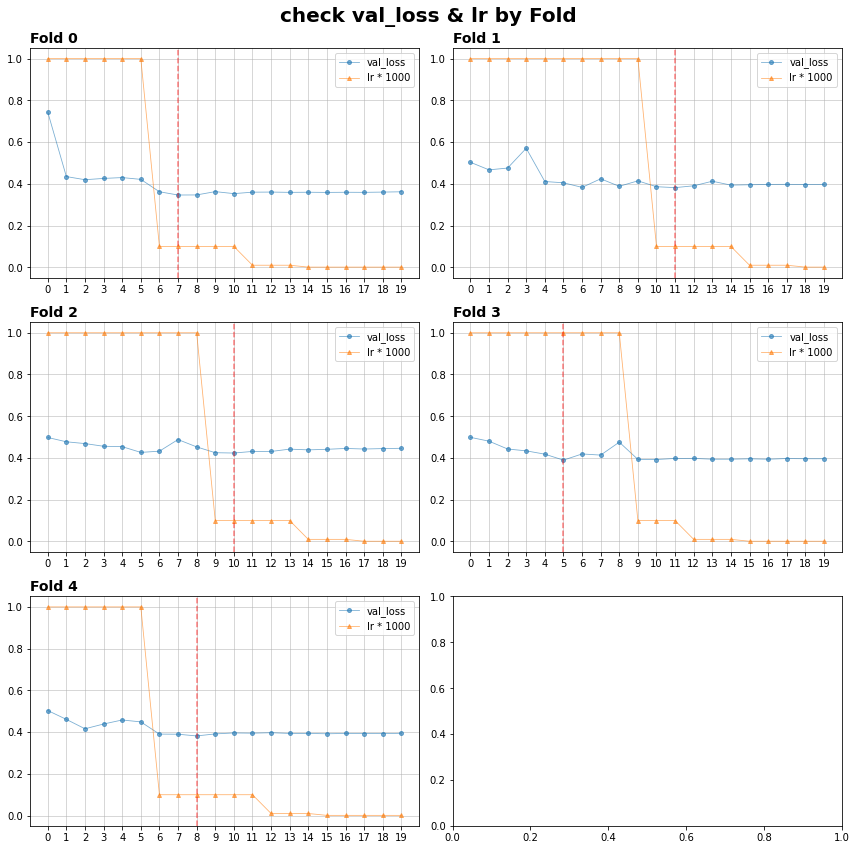

In [46]:
draw_plot(folder='./new_efnV2_cutmix/')

efnV2_large -> augmentation 만 default 로 학습시킨 것이 cv score 결과가 더 좋았다.  
왜 그럴까?(데이터에 문제가 있었기 때문 -> 제대로 학습할 수록 penalty)  
일단 제출해서 **LB 점수 비교** 해봐야겠다.
가능하면 앙상블도.  

* **2 classifier 비교**
    1. effnb7 : LB 0.608
    2. effnV2(change augmentation) : 
    3. effnV2 : LB 0.600
    4. 1+3 blending : LB 0.606
    
### 문제 현상 설명

efnV2_large 가 cv score 에서는 더 좋았지만, 실제 LB 에서는 efnb7 에 비해 점수가 하락했다.  
이유는 train data 와 test data 사이에 차이가 있었기 때문.(튜닝이 전부가 아니라, 데이터 확인 및 학습에 사용할 데이터를 잘 고르는 것의 중요성)   Discussion 에서 이 대회에 annotation 문제가 있었고, 시간관계상 test data 에만 수정이 적용되었다.  
즉, 데이터가 train data 는 오류 annotation data 가 섞여 있는 상황이 되었다.  
그 경우, train data 기반으로 계산하는 CV score 는 어찌되었든 그 안에서 학습(with eval_set)과 평가가 이루어지므로, 좋은 모델을 사용하면 점수가 더 좋아지지만, 제대로 학습했다고 볼 수 없다.  
그 결과로 잘못된 데이터로 학습했기 때문에, 올바른 데이터에서는 잘 예측하지 못하는 것.  
즉, CV score 지표와 기준 및 validation set (+ train set) 이 잘못되었기 때문에 문제가 일어난 것.   

바꿔도 좋아지지 않는다면, 768로 학습시켜보자. image_size 에 따른 차이가 있을 수 있으니.  

### efnV2_XL 가 성능이 더 좋지 않은 이유.
1. image_size
2. scheduling (model 에 맞는) - 초반부 학습이 잘 안되는 것 같다. (특히 Fold 3)

In [32]:
new_efnb7, model = load_history(folder='./new_effnb7/')
new_efnb7 = sorted(new_efnb7)
new_efnb7

['./new_effnb7/kaggle/working/effnetB7_model/history0_2class.csv',
 './new_effnb7/kaggle/working/effnetB7_model/history1_2class.csv',
 './new_effnb7/kaggle/working/effnetB7_model/history2_2class.csv',
 './new_effnb7/kaggle/working/effnetB7_model/history3_2class.csv',
 './new_effnb7/kaggle/working/effnetB7_model/history4_2class.csv']

In [30]:
pd.read_csv(new_efnb7[0])

,Unnamed: 0,loss,auc,val_loss,val_auc,lr
0,0,0.525765,0.768105,0.877543,0.856272,1.000000e-03
1,1,0.451971,0.837562,2.711256,0.618072,1.000000e-03
2,2,0.413179,0.865292,0.399478,0.887968,1.000000e-03
3,3,0.386550,0.883276,0.610501,0.897638,1.000000e-03
4,4,0.378188,0.887449,0.507280,0.883166,1.000000e-03
5,5,0.367358,0.897060,1.148764,0.849291,1.000000e-03
6,6,0.316557,0.925040,0.527707,0.898902,1.000000e-04
7,7,0.293948,0.934592,0.395737,0.911593,1.000000e-04
8,8,0.286504,0.939205,0.372780,0.912722,1.000000e-04
9,9,0.269844,0.945330,0.374633,0.911851,1.000000e-04


In [34]:
0.456 - 0.394, 0.002

(0.062, 0.002)

In [36]:
0.394 - 0.387

0.007000000000000006